In [ ]:
import cv2
import numpy as np

def apply_dct(block):
    return cv2.dct(block.astype(np.float32))

def apply_idct(block):
    return cv2.idct(block)

def fuse_dct_coefficients(dct1, dct2, method='average'):
    if method == 'average':
        return (dct1 + dct2) / 2
    elif method == 'max':
        return np.maximum(dct1, dct2)
    elif method == 'weighted':
        alpha = 0.6
        return alpha * dct1 + (1 - alpha) * dct2
    else:
        raise ValueError("Unknown fusion method")

def fuse_images(img1, img2, block_size=8, fusion_method='average'):
    h, w = img1.shape
    fused_img = np.zeros((h, w), np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block1 = img1[i:i+block_size, j:j+block_size]
            block2 = img2[i:i+block_size, j:j+block_size]

            dct1 = apply_dct(block1)
            dct2 = apply_dct(block2)

            fused_dct = fuse_dct_coefficients(dct1, dct2, fusion_method)

            fused_block = apply_idct(fused_dct)
            fused_img[i:i+block_size, j:j+block_size] = fused_block

    return np.clip(fused_img, 0, 255).astype(np.uint8)
def resize_images_to_same_size(img1, img2):
    # Determine the new size based on the smallest dimensions
    new_height = min(img1.shape[0], img2.shape[0])
    new_width = min(img1.shape[1], img2.shape[1])
    new_size = (new_width, new_height)

    # Resize both images
    resized_img1 = cv2.resize(img1, new_size, interpolation=cv2.INTER_AREA)
    resized_img2 = cv2.resize(img2, new_size, interpolation=cv2.INTER_AREA)

    return resized_img1, resized_img2
# Load images
img1 = cv2.imread('/content/00000.bmp', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/aeval1.bmp', cv2.IMREAD_GRAYSCALE)

img1,img2 = resize_images_to_same_size(img1,img2)
# Ensure images are the same size
if img1.shape!= img2.shape:
    raise ValueError("Input images must have the same dimensions")

# Fuse images
fused_img = fuse_images(img1, img2, block_size=8, fusion_method='average')

# Save or display the result
cv2.imwrite('fused_image.png', fused_img)


True

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

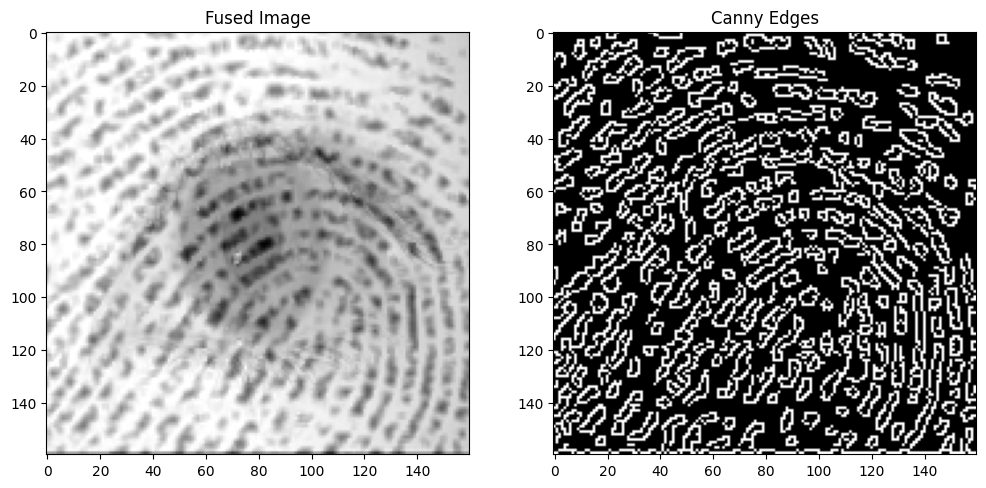

In [ ]:
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from skimage import feature
import pandas as pd
import matplotlib.pyplot as plt

# Load the fused image
fused_image = cv2.imread('fused_image.png', cv2.IMREAD_GRAYSCALE)

# Statistical Features
mean_intensity = np.mean(fused_image)
std_intensity = np.std(fused_image)
entropy_hist = cv2.calcHist([fused_image], [0], None, [256], [0, 256])
entropy = -np.sum(entropy_hist * np.log2(entropy_hist + 1e-5))

# Texture Features using GLCM
glcm = greycomatrix(fused_image, distances=[1], angles=[0], symmetric=True, normed=True)
contrast = greycoprops(glcm, 'contrast')[0, 0]
correlation = greycoprops(glcm, 'correlation')[0, 0]
energy = greycoprops(glcm, 'energy')[0, 0]
homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]

# Texture Features using LBP
radius = 3
n_points = 8 * radius
lbp = local_binary_pattern(fused_image, n_points, radius, method="uniform")
lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
lbp_hist = lbp_hist.astype("float")
lbp_hist /= lbp_hist.sum()  # Normalize the histogram

# Frequency Domain Features using DCT
dct_image = cv2.dct(np.float32(fused_image) / 255.0)
dct_coefficients = dct_image[:8, :8].flatten()

# Edge Features using Canny
edges = cv2.Canny(fused_image, 100, 200)
sum_edges = np.sum(edges)

# Keypoint Descriptors using SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(fused_image, None)
num_keypoints = len(keypoints)
descriptors_shape = descriptors.shape if descriptors is not None else (0, 0)

# Creating the feature space
features = {
    'mean_intensity': mean_intensity,
    'std_intensity': std_intensity,
    'entropy': entropy,
    'contrast': contrast,
    'correlation': correlation,
    'energy': energy,
    'homogeneity': homogeneity,
    'lbp_hist': lbp_hist.tolist(),  # Convert LBP histogram to a list
    'dct_coefficients': dct_coefficients.tolist(),  # Convert DCT coefficients to a list
    'sum_edges': sum_edges,
    'num_keypoints': num_keypoints,
    'descriptors_shape': descriptors_shape
}

# Convert the dictionary to a pandas dataframe
df = pd.DataFrame([features])




# Save the dataframe to a CSV file (or other format as needed)
df.to_csv('fused_image_features.csv', index=False)

# Visualization (optional)
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(fused_image, cmap='gray'), plt.title('Fused Image')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Canny Edges')
plt.show()

In [ ]:
display(df)

,mean_intensity,std_intensity,entropy,contrast,correlation,energy,homogeneity,lbp_hist,dct_coefficients,sum_edges,num_keypoints,descriptors_shape
0,195.017695,40.245952,-193121.671875,264.737186,0.918425,0.025929,0.143701,"[0.0640234375, 0.0423828125, 0.031171875, 0.02...","[122.36402893066406, 7.729726314544678, 6.4164...",1737570,995,"(995, 128)"


###Generative Autoencoders and Variational autoencoders cannot generate fused images given two images exactly so these provide better Biometric Data-security compared to UniBiometrics

###GradientBoostingRegressor for fusion at score level

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Example feature vectors for training (these should be your actual data)
# feature_vector_1 and feature_vector_2 are numpy arrays with the same length
feature_vector_1 = np.array([0.8, 0.6, 0.9, 0.7, 0.5])
feature_vector_2 = np.array([0.7, 0.65, 0.85, 0.72, 0.4])
# Example combined scores (target values for training)
combined_scores = np.array([0.75, 0.63, 0.87, 0.71, 0.45])

# Combine feature vectors into a single dataset
X = np.vstack((feature_vector_1, feature_vector_2)).T
y = combined_scores

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting Regressor model
regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
regressor.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error: {mse:.2f}")

# Example of generating combination score on new data
new_feature_vector_1 = np.array([0.75])
new_feature_vector_2 = np.array([0.8])
new_X = np.vstack((new_feature_vector_1, new_feature_vector_2)).T

# Get the combined score
combined_score = regressor.predict(new_X)
print(f"Combined Score: {combined_score[0]:.2f}")


Test Mean Squared Error: 0.01
Combined Score: 0.78
